# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [86]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from prettytable import PrettyTable
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).

def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
# from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [14]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [15]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [16]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:35<00:00, 2469.01it/s]


In [17]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

# [4] Splitting the Data

Before splitting the data in train, cross validation and test , we put all the pre processed reviews in x and corresponding class labels into y.

In [18]:
x = preprocessed_reviews
y = final["Score"].values

Splitting the data as train data, cross validation data and test data

In [19]:
# splitting the data into 3 parts for furhter process, 
# train data, cross validation data and test data

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30)         # this is random splitting
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.30) # this is random splitting



In [20]:
# number of rows in earch data set, train, cross validation and test data respectively
print(len(x_train))
print(len(x_cv))
print(len(x_test))

43008
18433
26332


# [5] Featurization

## [5.1] BAG OF WORDS

In [24]:
# BoW using scikit-learn


count_vect = CountVectorizer(min_df=10, max_features=10000)  
count_vect.fit(x_train)

print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

# we use the fitted CountVectorizer to convert the text to vector
x_train_bow = count_vect.transform(x_train)
x_cv_bow    = count_vect.transform(x_cv)
x_test_bow  = count_vect.transform(x_test)

print("After vectorizations")

print(x_train_bow.shape, y_train.shape)
print(x_cv_bow.shape, y_cv.shape)
print(x_test_bow.shape, y_test.shape)


some feature names  ['ability', 'able', 'absence', 'absent', 'absolute', 'absolutely', 'absolutley', 'absolutly', 'absorb', 'absorbed']
After vectorizations
(43008, 8076) (43008,)
(18433, 8076) (18433,)
(26332, 8076) (26332,)


## [5.2] TF-IDF

In [23]:
# TFIDF using scikit-learn

tf_idf_vect = TfidfVectorizer(min_df=10, max_features=10000)               #in scikit-learn
tf_idf_vect.fit(x_train)

print("some sample features",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

# we use fit() method to learn the vocabulary from x_train 
# and now transform text data to vectors using transform() method

x_train_tfidf = tf_idf_vect.transform(x_train)
x_cv_tfidf    = tf_idf_vect.transform(x_cv)
x_test_tfidf  = tf_idf_vect.transform(x_test)

print("After featurization\n")

print(x_train_tfidf.shape, y_train.shape)
print(x_cv_tfidf.shape, y_cv.shape)
print(x_test_tfidf.shape, y_test.shape)


some sample features ['ability', 'able', 'absence', 'absent', 'absolute', 'absolutely', 'absolutley', 'absolutly', 'absorb', 'absorbed']
After featurization

(43008, 8076) (43008,)
(18433, 8076) (18433,)
(26332, 8076) (26332,)


# [6] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

## [6.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

So let's find a best value for our hyperparameter here using GridSearch hyperparameter tuning.

In [44]:
lg_alp = []
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

for i in alpha :
    lg_alp.append(math.log10(i))

print(lg_alp)

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]


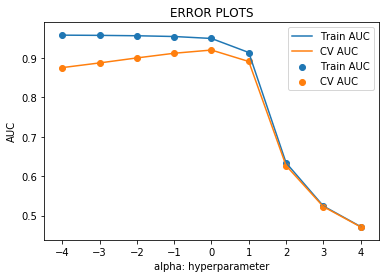

Model with best parameters :
 MultinomialNB(alpha=1, class_prior=None, fit_prior=True)


In [40]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

parameters = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
nb = MultinomialNB()

grid = GridSearchCV(nb, parameters, cv=4, scoring='roc_auc', n_jobs=-1)
grid.fit(x_train_bow, y_train)

train_auc_bow      = grid.cv_results_['mean_train_score']
cv_auc_bow         = grid.cv_results_['mean_test_score'] 


plt.plot(lg_alp, train_auc_bow, label='Train AUC')
plt.scatter(lg_alp, train_auc_bow, label='Train AUC')

plt.plot(lg_alp, cv_auc_bow, label='CV AUC')
plt.scatter(lg_alp, cv_auc_bow, label='CV AUC')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
print("Model with best parameters :\n",grid.best_estimator_)

In [41]:
best_alpha = 1

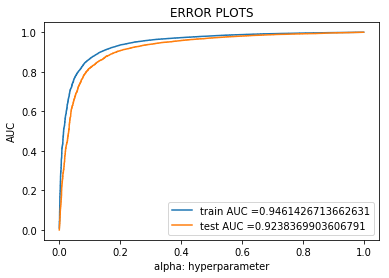

In [77]:
nb = MultinomialNB(alpha = best_alpha)
nb.fit(x_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr_bow, train_tpr_bow, thresholds_bow = roc_curve(y_train, nb.predict_proba(x_train_bow)[:,1])
test_fpr_bow, test_tpr_bow, thresholds_bow = roc_curve(y_test, nb.predict_proba(x_test_bow)[:,1])

plt.plot(train_fpr_bow, train_tpr_bow, label="train AUC ="+str(auc(train_fpr_bow, train_tpr_bow)))
plt.plot(test_fpr_bow, test_tpr_bow, label="test AUC ="+str(auc(test_fpr_bow, test_tpr_bow)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


Train Confusion Matrix


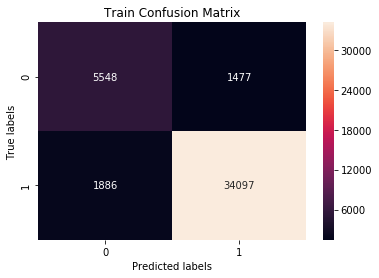

In [120]:
print("Train Confusion Matrix")
cm_tr = confusion_matrix(y_train, grid.predict(x_train_bow))
sns.heatmap(cm_tr, annot=True, fmt= 'd') # annot=True to annotate cells

# labels, title and ticks
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Train Confusion Matrix')
plt.show()


Test Confusion Matrix


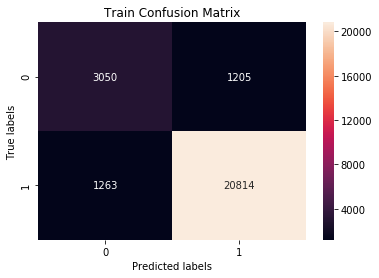

In [121]:
print("Test Confusion Matrix")
cm_te = confusion_matrix(y_test, grid.predict(x_test_bow))
sns.heatmap(cm_te, annot=True, fmt='g')

# labels, title and ticks
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Train Confusion Matrix')
plt.show()


### [6.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [82]:
nb.classes_

array([0, 1], dtype=int64)

In [83]:
# Now we can find log probabilities of different features for both the classes
class_features = nb.feature_log_prob_

#  row_0 is for 'negative' class and row_1 is for 'positive' class
negative_features = class_features[0]
positive_features = class_features[1]

# Getting all feature names
feature_names = count_vect.get_feature_names()

# Sorting 'negative_features' and 'positive_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]
sorted_positive_features = np.argsort(positive_features)[::-1]

print("\n\nTop 10 Important Features and their log probabilities For Positive Class :\n\n")
for i in list(sorted_positive_features[0:10]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))  



Top 10 Important Features and their log probabilities For Positive Class :


not	 -->	-3.679396  
like	 -->	-4.480949  
good	 -->	-4.621951  
great	 -->	-4.676597  
one	 -->	-4.832851  
taste	 -->	-4.916672  
coffee	 -->	-4.930744  
flavor	 -->	-5.005918  
would	 -->	-5.020401  
love	 -->	-5.028871  


### [6.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [84]:
print("Top 10 Important Features and their log probabilities For Negative Class :\n\n")
for i in list(sorted_negative_features[0:10]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))
    


Top 10 Important Features and their log probabilities For Negative Class :


not	 -->	-3.235728  
like	 -->	-4.350658  
would	 -->	-4.637823  
taste	 -->	-4.649252  
product	 -->	-4.691221  
one	 -->	-4.871003  
good	 -->	-5.062585  
coffee	 -->	-5.081188  
flavor	 -->	-5.137463  
no	 -->	-5.181554  


In [114]:
# evaluating train: accuracy, precison, recall and f1_score

predictions = nb.predict(x_train_bow)

acc_tr = accuracy_score(y_train, predictions)
print('Accuracy score: ', acc_tr)

pre_tr = precision_score(y_train, predictions)
print('Precision score: ', pre_tr)

rec_tr = recall_score(y_train, predictions)
print('Recall score: ', rec_tr)

f1_tr = f1_score(y_train, predictions)
print('F1 score: ', f1_tr)

Accuracy score:  0.9190150669642857
Precision score:  0.9578238575533893
Recall score:  0.9448072700997693
F1 score:  0.9512710382360758


In [113]:
# evaluating test: accuracy, precision, recall and f1_score
predictions = nb.predict(x_test_bow)

acc_te = accuracy_score(y_test, predictions)
print('Accuracy score: ', acc_te)

pre_te = precision_score(y_test, predictions)
print('Precision score: ', pre_te)

rec_te = recall_score(y_test, predictions)
print('Recall score: ', rec_te)

f1_te = f1_score(y_test, predictions)
print('F1 score: ', f1_te)

Accuracy score:  0.9011089169071852
Precision score:  0.9430716723549488
Recall score:  0.9387144992526159
F1 score:  0.9408880414056116


## [6.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

Hyperparameter tuning using grid search

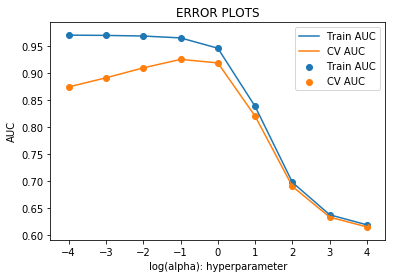

Model with best parameters :
 MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)


In [93]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

nb = MultinomialNB()
parameters = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
grid = GridSearchCV(nb, parameters, cv=3, scoring='roc_auc', n_jobs=-1)
grid.fit(x_train_tfidf, y_train)

train_auc_tfidf      = grid.cv_results_['mean_train_score']
cv_auc_tfidf         = grid.cv_results_['mean_test_score'] 

plt.plot(lg_alp, train_auc_tfidf, label='Train AUC')
plt.scatter(lg_alp, train_auc_tfidf, label='Train AUC')

plt.plot(lg_alp, cv_auc_tfidf, label='CV AUC')
plt.scatter(lg_alp, cv_auc_tfidf, label='CV AUC')

plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
print("Model with best parameters :\n",grid.best_estimator_)

In [94]:
best_alpha_tfidf = 0.1

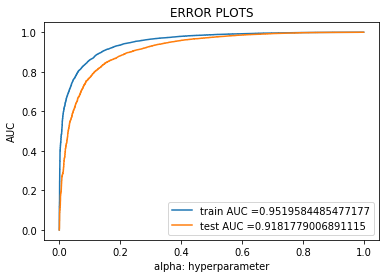

In [96]:
nb = MultinomialNB(alpha = best_alpha_tfidf) 
nb.fit(x_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr_tfidf, train_tpr_tfidf, thresholds_tfidf = roc_curve(y_train, nb.predict_proba(x_train_tfidf)[:,1])
test_fpr_tfidf, test_tpr_tfidf, thresholds_tfidf = roc_curve(y_test, nb.predict_proba(x_test_tfidf)[:,1])

plt.plot(train_fpr_tfidf, train_tpr_tfidf, label="train AUC ="+str(auc(train_fpr_tfidf, train_tpr_tfidf)))
plt.plot(test_fpr_tfidf, test_tpr_tfidf, label="test AUC ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


Train Confusion Matrix


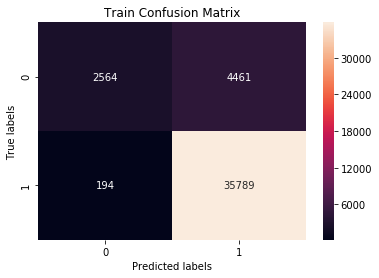

In [117]:
print("Train Confusion Matrix")
cm_tr = confusion_matrix(y_train, grid.predict(x_train_tfidf))
sns.heatmap(cm_tr, annot=True, fmt= 'd') # annot=True to annotate cells

# labels, title and ticks
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Train Confusion Matrix')
plt.show()


Train Confusion Matrix


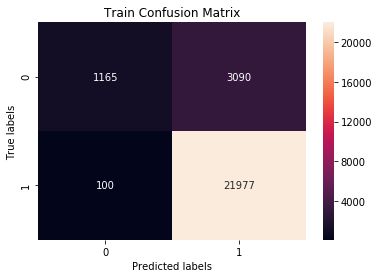

In [122]:
print("Train Confusion Matrix")
cm_te = confusion_matrix(y_test, grid.predict(x_test_tfidf))
sns.heatmap(cm_te, annot=True, fmt= 'd') # annot=True to annotate cells

# labels, title and ticks
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Train Confusion Matrix')
plt.show()


### [6.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [ ]:
# https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob/master/Apply%20Naive%20Bayes%20on%20Amazon%20Fine%20Food%20Reviews.ipynb

In [97]:
nb.classes_

array([0, 1], dtype=int64)

In [98]:
# Now we can find log probabilities of different features for both the classes
class_features = nb.feature_log_prob_

#  row_0 is for 'negative' class and row_1 is for 'positive' class
negative_features = class_features[0]
positive_features = class_features[1]

# Getting all feature names
feature_names = tf_idf_vect.get_feature_names()

# Sorting 'negative_features' and 'positive_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]
sorted_positive_features = np.argsort(positive_features)[::-1]



In [99]:
print("\n\nTop 10 Important Features and their log probabilities For Positive Class :\n\n")
for i in list(sorted_positive_features[0:10]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))    



Top 10 Important Features and their log probabilities For Positive Class :


not	 -->	-3.673939  
like	 -->	-4.475525  
good	 -->	-4.616536  
great	 -->	-4.671185  
one	 -->	-4.827452  
taste	 -->	-4.911280  
coffee	 -->	-4.925353  
flavor	 -->	-5.000535  
would	 -->	-5.015020  
love	 -->	-5.023491  


### [6.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [100]:
print("Top 10 Important Features and their log probabilities For Negative Class :\n\n")
for i in list(sorted_negative_features[0:10]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))


Top 10 Important Features and their log probabilities For Negative Class :


not	 -->	-3.211281  
like	 -->	-4.326367  
would	 -->	-4.613610  
taste	 -->	-4.625042  
product	 -->	-4.667025  
one	 -->	-4.846872  
good	 -->	-5.038536  
coffee	 -->	-5.057148  
flavor	 -->	-5.113451  
no	 -->	-5.157564  


In [111]:
# evaluating train: accuracy, precison, recall and f1_score

predictions1 = nb.predict(x_train_tfidf)

acc_tr1 = accuracy_score(y_train, predictions1)
print('Accuracy score: ', acc_tr1)

pre_tr1 = precision_score(y_train, predictions1)
print('Precision score: ', pre_tr1)

rec_tr1 = recall_score(y_train, predictions1)
print('Recall score: ', rec_tr1)

f1_tr1 = f1_score(y_train, predictions1)
print('F1 score: ', f1_tr1)

Accuracy score:  0.8858119419642857
Precision score:  0.8829619404456714
Recall score:  0.9954700830947948
F1 score:  0.9358466904416665


In [112]:
# evaluating test accuracy, precison, recall, f1_score

predictions1 = nb.predict(x_test_tfidf)
acc_te1 = accuracy_score(y_test, predictions1)
print('Accuracy score: ', acc_te1)

pre_te1 = precision_score(y_test, predictions1)
print('Precision score: ', pre_te1)

rec_te1 = recall_score(y_test, predictions1)
print('Recall score: ', rec_te1)

f1_te1 = f1_score(y_test, predictions1)
print('F1 score: ', f1_te1)

Accuracy score:  0.873310041014735
Precision score:  0.8712412344994256
Recall score:  0.996104543189745
F1 score:  0.9294982881778604


# [7] Conclusions

In [115]:
# Creating table using PrettyTable library

names = ["MultinomialNB for BoW", "MultinomialNB for TFIDF"]

optimal_alpha = [ best_alpha, best_alpha_tfidf]

#train_acc = [ train_auc_bow, train_auc_tfidf]

train_acc = [ acc_tr, acc_tr1]
test_acc  = [ acc_te, acc_te1]

numbering = [1,2]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best Alpha",optimal_alpha)
ptable.add_column("Train Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)
#ptable.add_column("Training Accuracy",train_acc)
#ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+-------------------------+------------+--------------------+--------------------+
| S.NO. |          MODEL          | Best Alpha |   Train Accuracy   |   Test Accuracy    |
+-------+-------------------------+------------+--------------------+--------------------+
|   1   |  MultinomialNB for BoW  |     1      | 0.9190150669642857 | 0.9011089169071852 |
|   2   | MultinomialNB for TFIDF |    0.1     | 0.8858119419642857 | 0.873310041014735  |
+-------+-------------------------+------------+--------------------+--------------------+
